In [1]:
import json
from collections import Counter
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
import plotly.express as px
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import nltk
from nltk.tokenize import word_tokenize

c:\Users\faceru\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
with open('data/chunked_data/gdpr_clean.json') as f: 
    gdpr_clean = json.load(f)

### Descriptive Statistics

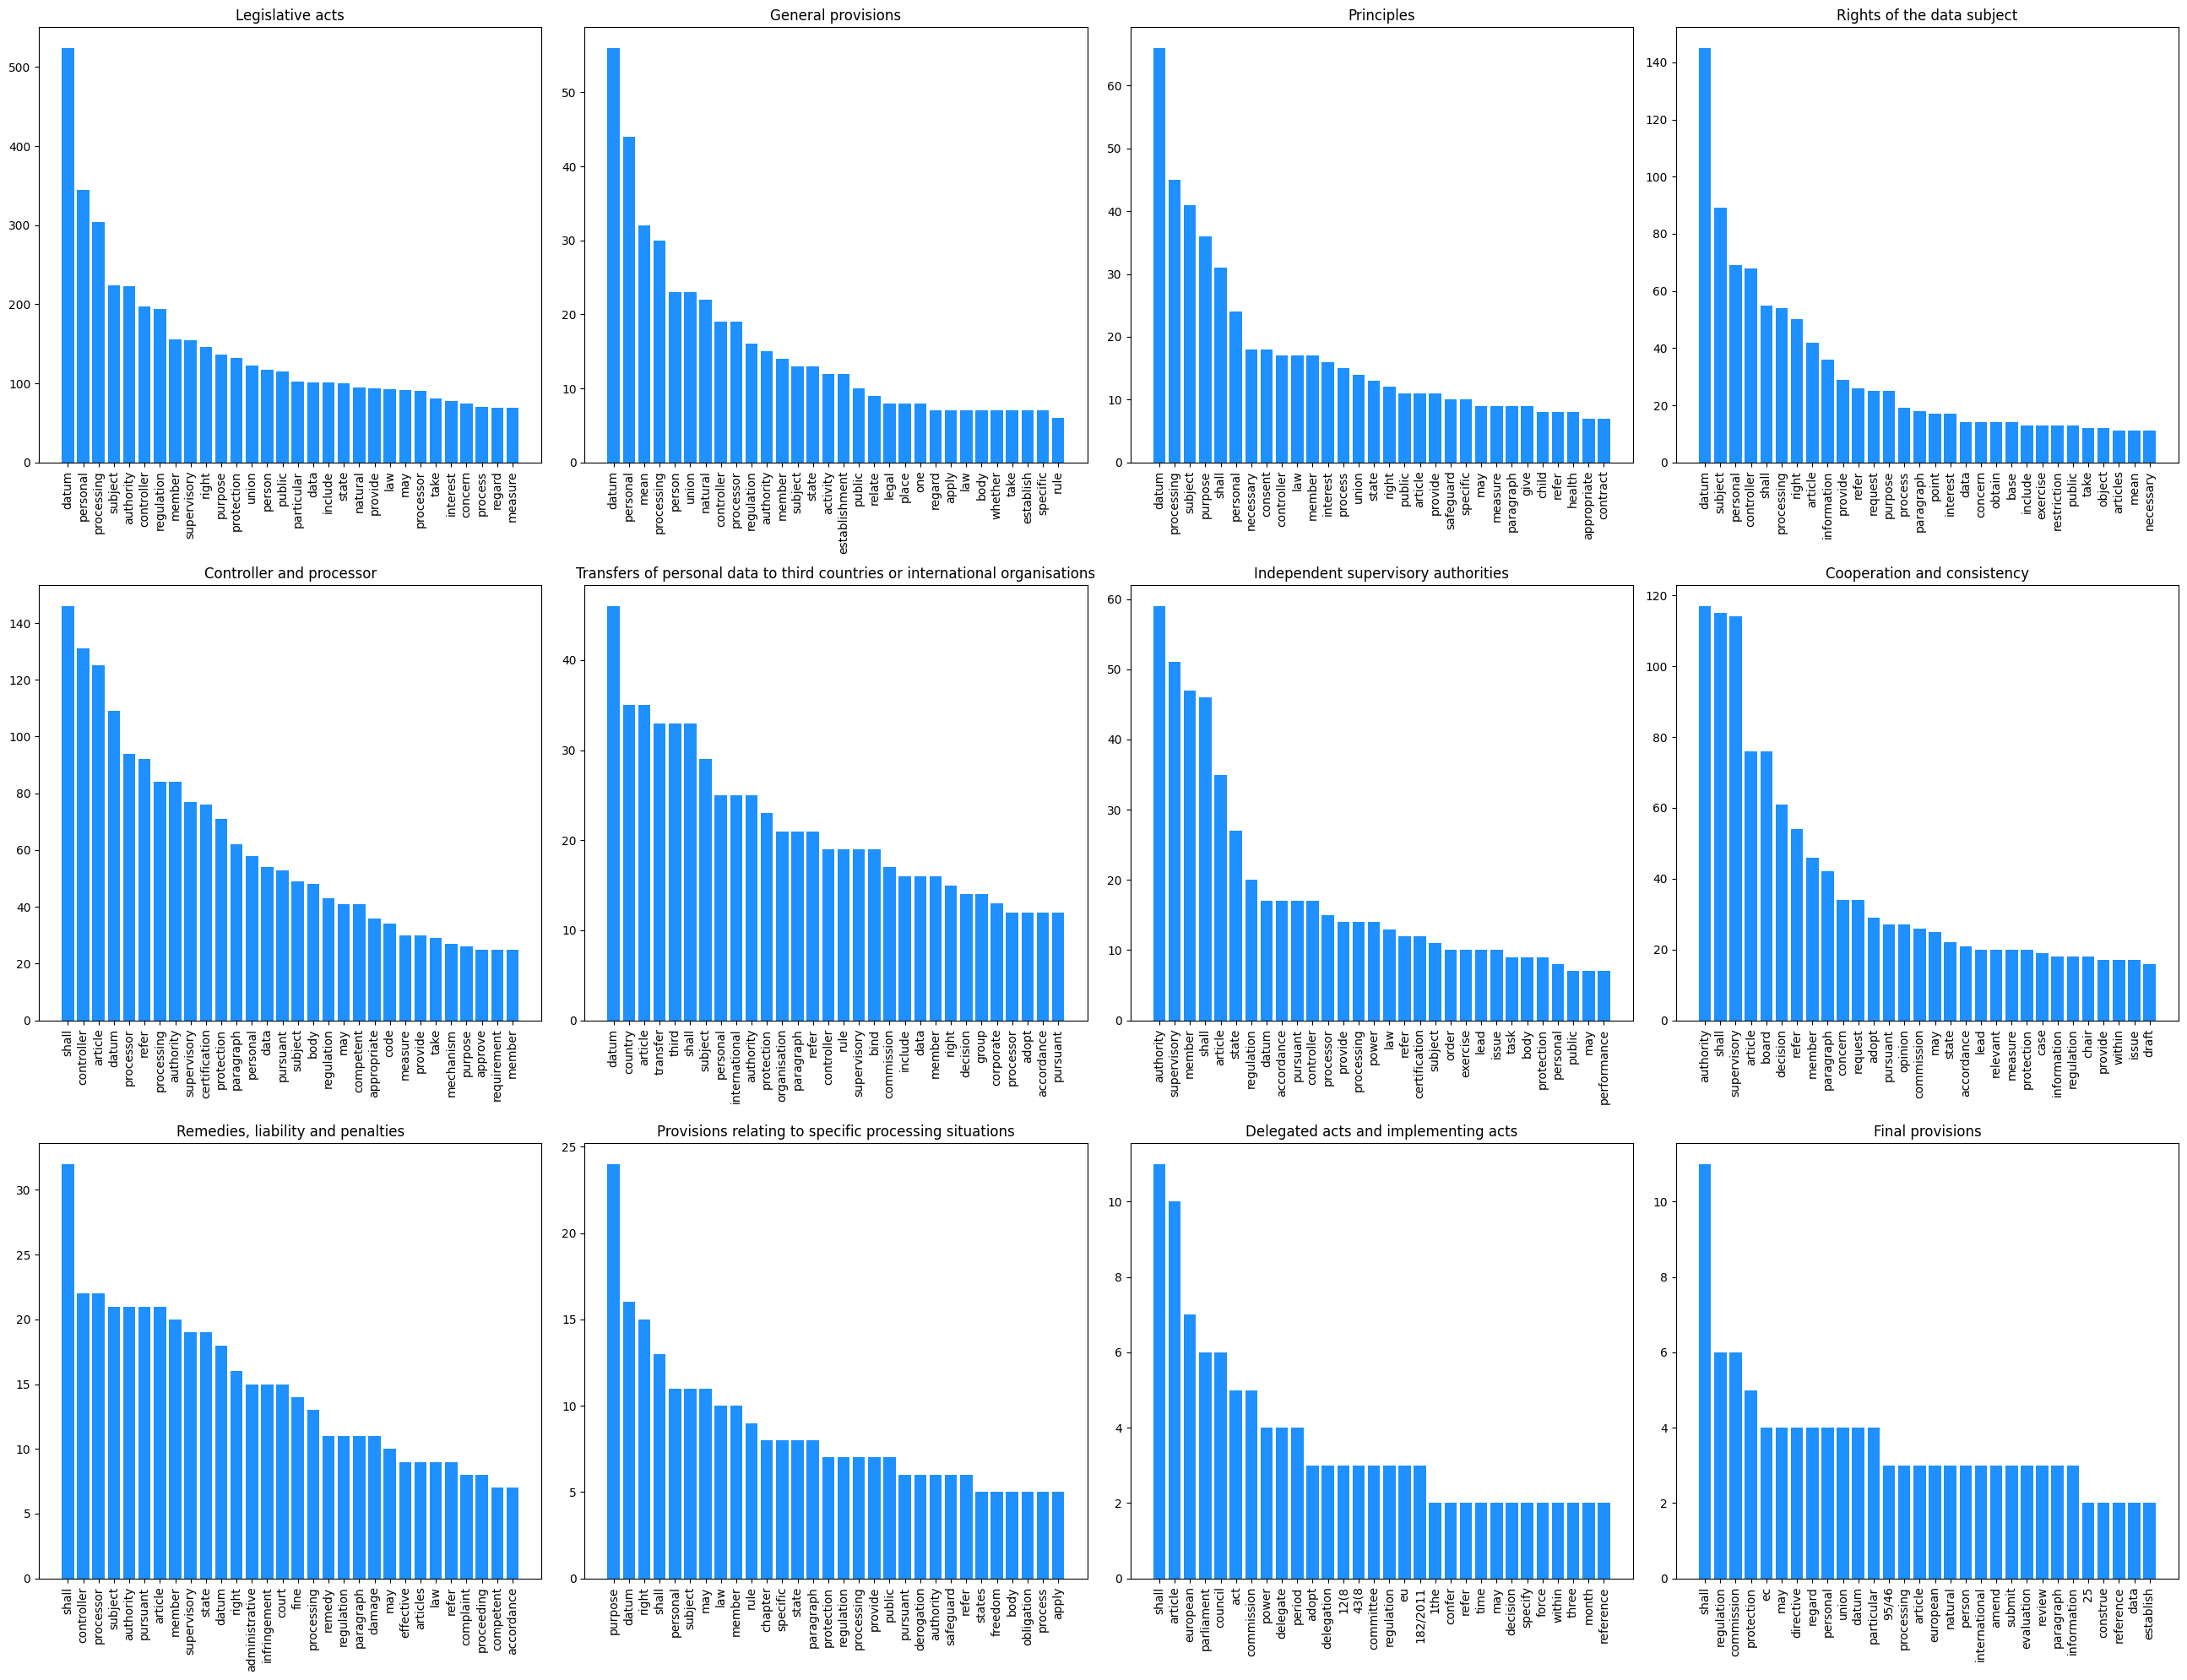

In [3]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(26,20))
axs=axs.ravel()
chapters = list(gdpr_clean.keys())
for i in range(len(axs)):
    ax = axs[i]
    chapter = chapters[i]
    top_20_words = Counter(' '.join(gdpr_clean[chapter].values()).split()).most_common(30)
    x_labs = [x for x,y in top_20_words]
    y_vals = [y for x,y in top_20_words]
    ax.bar(x=x_labs, height=y_vals, color='dodgerblue')
    ax.set_title(f'{chapter}')
    ax.tick_params(axis='x', labelrotation=90)

plt.tight_layout()    
plt.show()

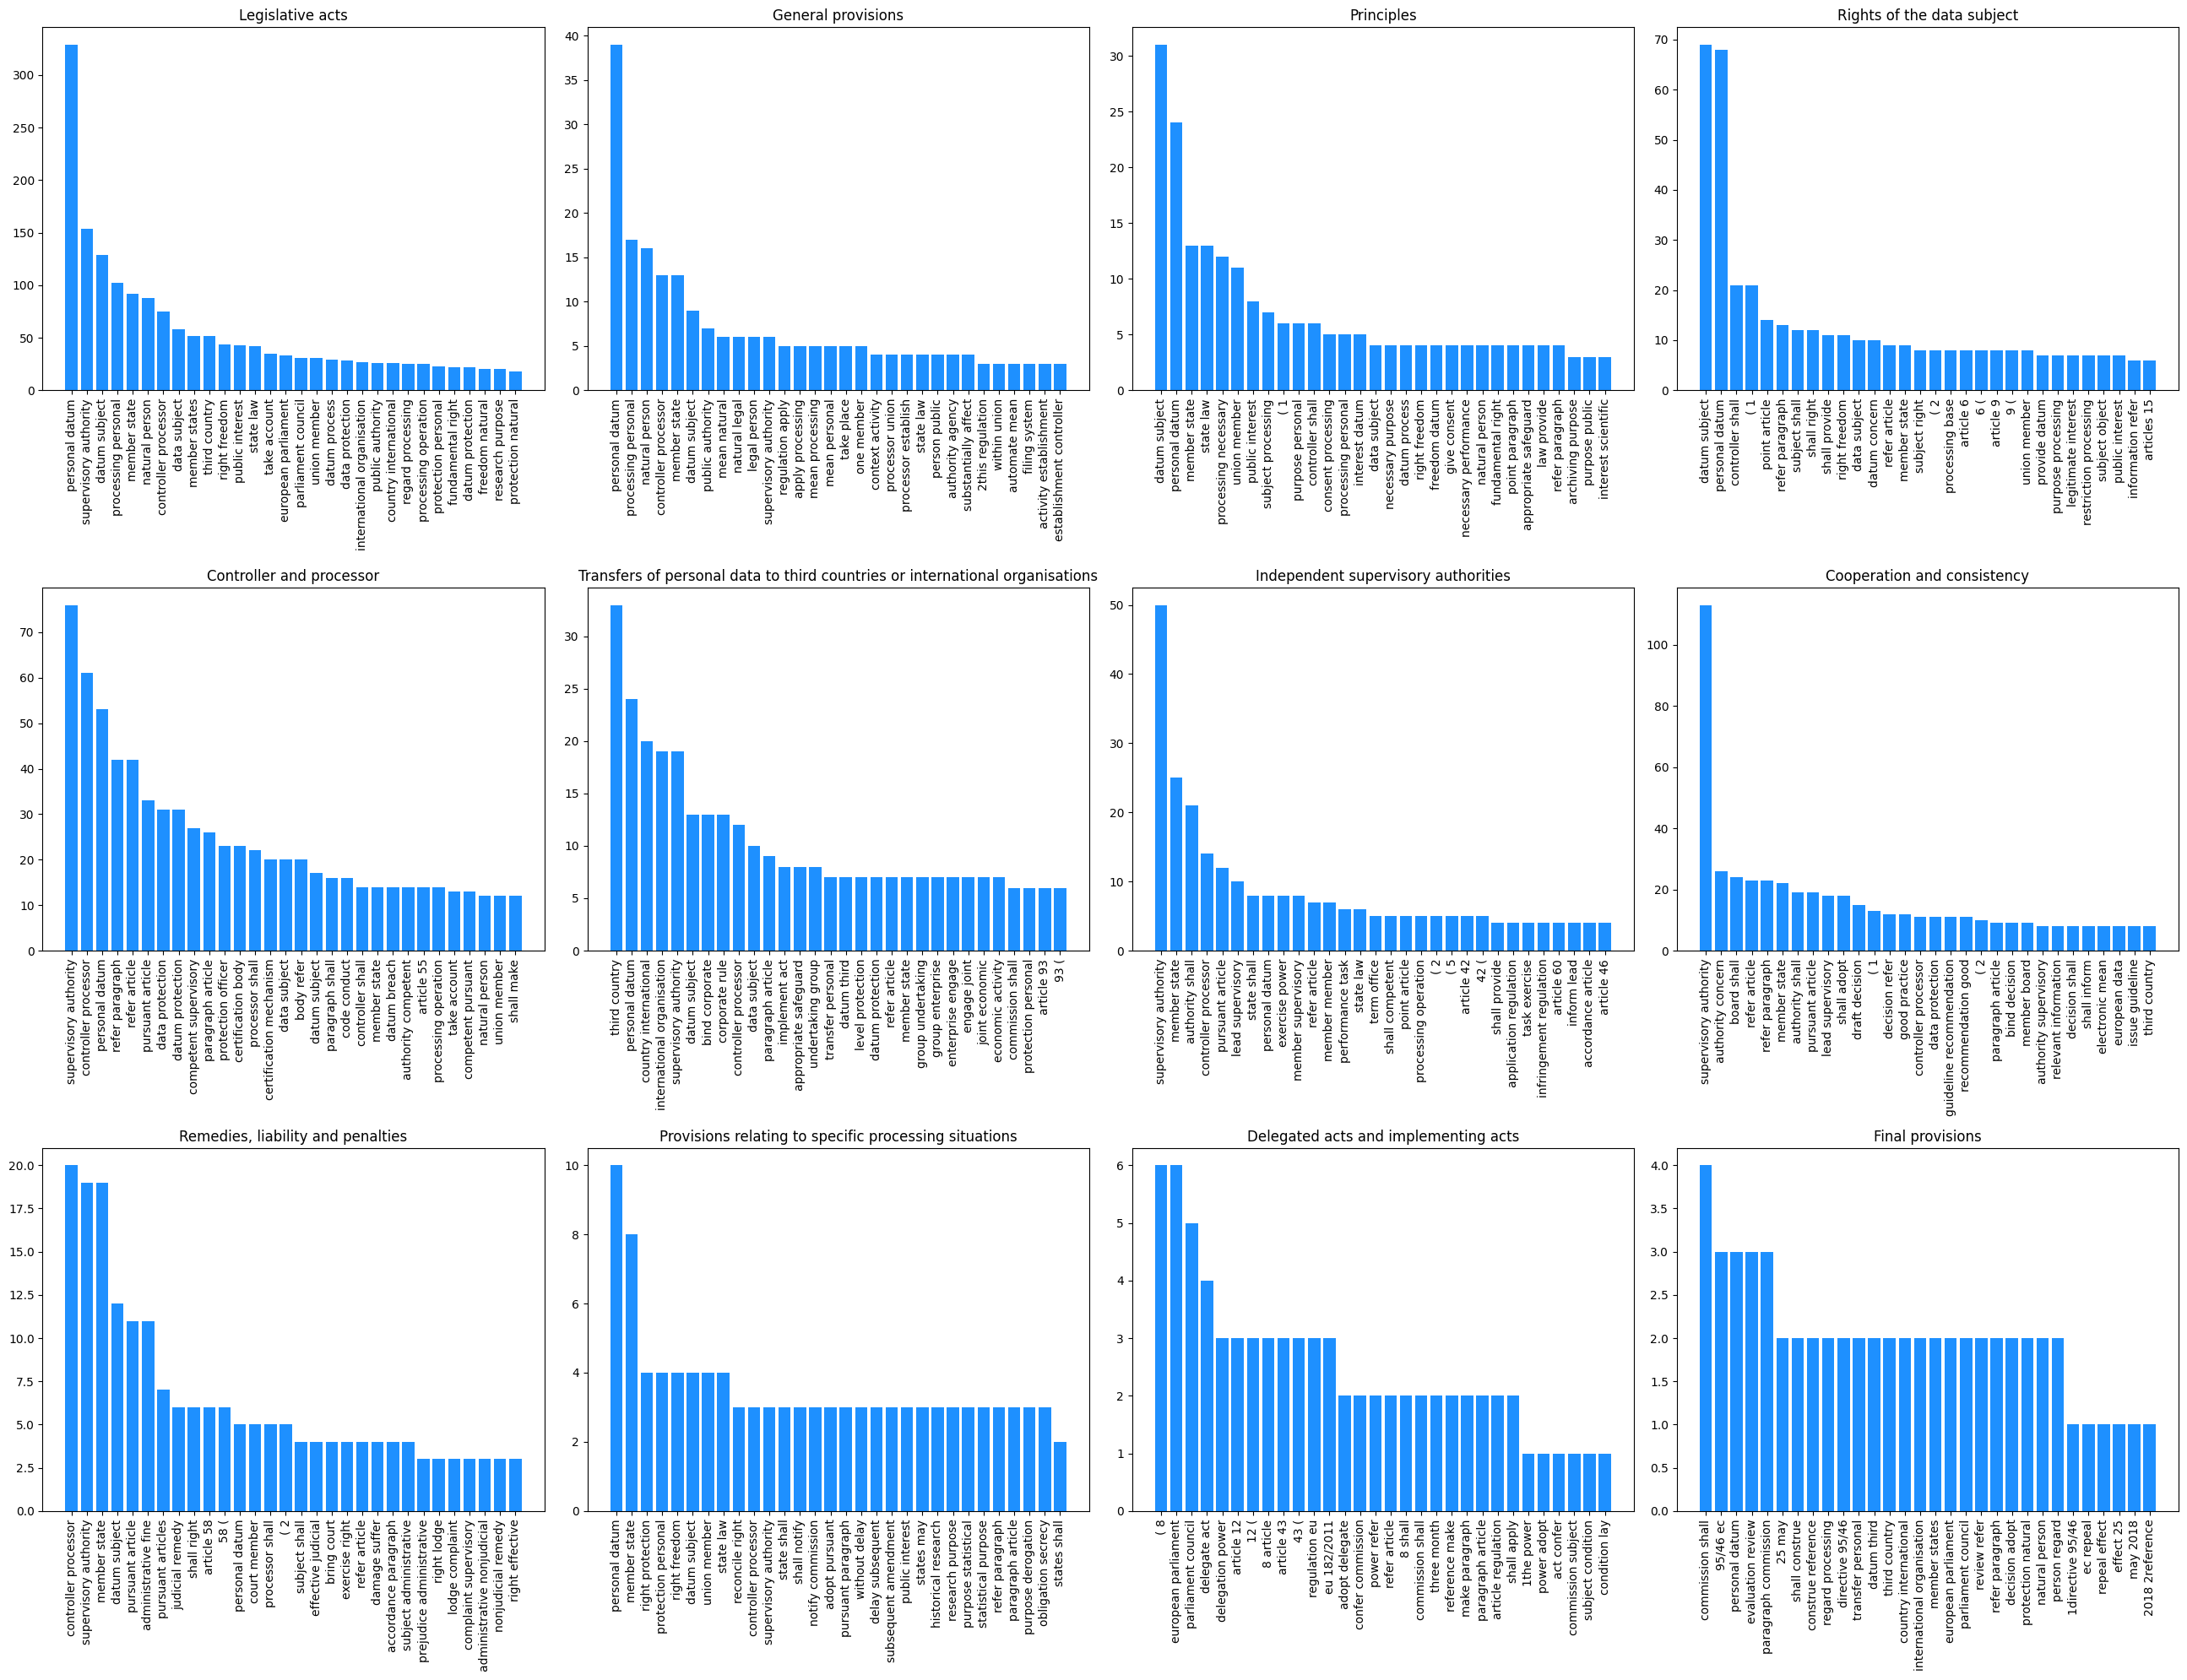

In [4]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(26,20))
axs=axs.ravel()
for i in range(len(axs)):
    ax = axs[i]
    chapter = chapters[i]
    top_20_bigrams = Counter([k for k in nltk.bigrams(word_tokenize(''.join(gdpr_clean[chapter].values())))]).most_common(30)
    x_labs = [x for x,y in top_20_bigrams]
    x_labs = [k[0]+' '+k[1] for k in x_labs]
    y_vals = [y for x,y in top_20_bigrams]
    ax.bar(x=x_labs, height=y_vals, color='dodgerblue')
    ax.set_title(f'{chapter}')
    ax.tick_params(axis='x', labelrotation=90)

plt.tight_layout()    
plt.show()

### TF-IDF

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re

articles = [re.sub('[0-9]*','',gdpr_clean[i][k]) for i in gdpr_clean.keys() for k in gdpr_clean[i].keys()] #remove all numbers as they clutter the words

tfidf_vectorizer=TfidfVectorizer(min_df=0.05, #I am considering words that appear at least in 1% of the articles
                                 max_df=0.65, #I am considering words that appear at most in 70% of the articles
                                 ngram_range=(1,2)) 

vectors = tfidf_vectorizer.fit_transform(articles)
feature_names=tfidf_vectorizer.get_feature_names_out()

In [30]:
tfidf_embeddings = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42).fit_transform(vectors)
tfidf_rep = pd.DataFrame({'Chapter': [i for i in gdpr_clean.keys() for k in gdpr_clean[i].keys()], 
                          'X_Embedding': tfidf_embeddings[:,0],
                          'Y_Embedding': tfidf_embeddings[:,1]})

px.scatter(tfidf_rep, 'X_Embedding', 'Y_Embedding', color='Chapter', color_discrete_sequence=px.colors.qualitative.Dark24)

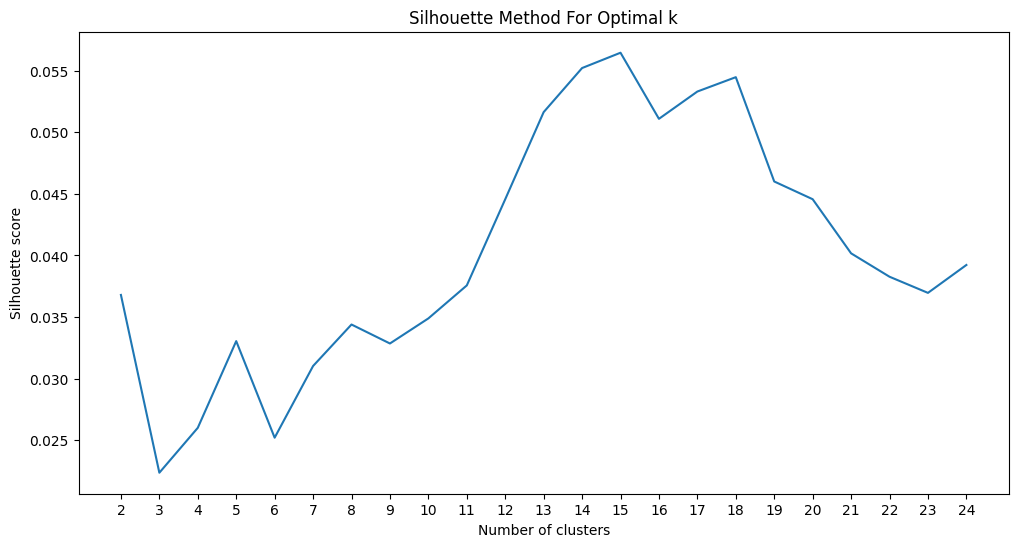

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
silhouettes = []
K = range(2, 25)

for c in K:
    kmeans_clustering = KMeans(n_clusters=c, init='k-means++', max_iter=1500, random_state=42, tol=1e-6)
    kmeans_ids = kmeans_clustering.fit_predict(vectors)
    score = silhouette_score(vectors, kmeans_clustering.labels_)
    silhouettes.append(score)

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(K, silhouettes)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette Method For Optimal k')
ax.set_xticks(np.arange(min(K), max(K)+1, 1.0))

plt.show()

In [34]:
clusters=15
model=KMeans(n_clusters=clusters, init='k-means++', max_iter=1500, random_state=42, tol=1e-6)
model.fit(vectors)
order_centroids=model.cluster_centers_.argsort()[:, ::-1]

for i in range(clusters):
    l=[]
    for j in order_centroids[i, :15]: #keeping only the first 15 words
        l.append(feature_names[j])
    print(f'Cluster {i}: {l}')

Cluster 0: ['processor', 'protection', 'controller processor', 'controller', 'protection officer', 'officer', 'data protection', 'processing', 'data', 'the', 'operation', 'reference', 'task', 'datum protection', 'assessment']
Cluster 1: ['personal datum', 'datum subject', 'controller', 'processing', 'recipient', 'information', 'rectification', 'right', 'obtain', 'controller shall', 'subject shall', 'existence', 'category', 'applicable', 'shall right']
Cluster 2: ['datum subject', 'controller', 'purpose', 'personal datum', 'processing', 'consent', 'right', 'process', 'child', 'exercise', 'relation', 'subject shall', 'object', 'legal', 'paragraph']
Cluster 3: ['chapter', 'amendment', 'state shall', 'each', 'each member', 'subsequent amendment', 'delay subsequent', 'notify commission', 'amendment affect', 'pursuant', 'fine', 'subsequent', 'rule', 'law', 'infringement']
Cluster 4: ['controller', 'processing', 'processor', 'organisational measure', 'measure', 'technical', 'technical organis

In [35]:
clust_dict = {0:'Controller and Processor',
              1:'Processing Personal Data',
              2:'Processing Consent',
              3:'Data Breach Consequences',
              4:'Controller Obligations',
              5:'Board and Supervisory Authority',
              6:'Supervisory/Certification Authority',
              7:'Supervisory Authority Power',
              8:'GDPR Regulation',
              9:'Personal Data Transfers',
              10:'Data Subject Rights',
              11:'Personal Data Subjects',
              12:'Data Breach Notification',
              13:'EU Court Intervention',
              14:'Supervisory Authority Cooperation Request'}

In [36]:
tfidf_rep['Cluster'] = model.predict(vectors) 
tfidf_rep['Cluster_Type'] = tfidf_rep['Cluster'].map(clust_dict)
px.scatter(tfidf_rep, 'X_Embedding', 'Y_Embedding', color='Cluster_Type', color_discrete_sequence=px.colors.qualitative.Dark24)

### LLM Embeddings

In [39]:
from tqdm import tqdm

In [40]:
model = SentenceTransformer('intfloat/multilingual-e5-large-instruct') 
embeddings = []
chapter = []
article = []
for k in tqdm(gdpr_clean.keys()):
    for sub_k in gdpr_clean[k].keys():
        embeddings.append(model.encode(gdpr_clean[k][sub_k], normalize_embeddings=True))
        chapter.append(k)
        article.append(sub_k)
embeddings = np.array(embeddings)

100%|██████████| 12/12 [02:03<00:00, 10.28s/it]


In [41]:
embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42).fit_transform(embeddings)
embedded_df = pd.DataFrame({'x': embedded[:,0], 'y':embedded[:,1], 'chapter':chapter, 'article':article})
px.scatter(embedded_df, 'x', 'y', color='chapter', color_discrete_sequence=px.colors.qualitative.Dark24)

### Topic Modelling

In [46]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary

In [76]:
splitted_articles = [i.split(' ') for i in articles]
dictionary = Dictionary(splitted_articles)
dictionary.filter_extremes(no_above=0.4)
ldacorpus = [dictionary.doc2bow(i) for i in splitted_articles]
tfidf = TfidfModel(ldacorpus)
model_corpus = tfidf[ldacorpus]

numtop=[]
coherence_umass = []
coherence_cv=[]

for num_topics in tqdm(range(2, 20)): 
    model = LdaMulticore(corpus=model_corpus, 
                         id2word=dictionary, 
                         num_topics=num_topics, random_state=42,
                         passes=10)     

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=splitted_articles, 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=splitted_articles, 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    numtop.append(num_topics)
    coherence_umass.append(umass_score)
    coherence_cv.append(cv_score)

100%|██████████| 18/18 [02:59<00:00,  9.95s/it]


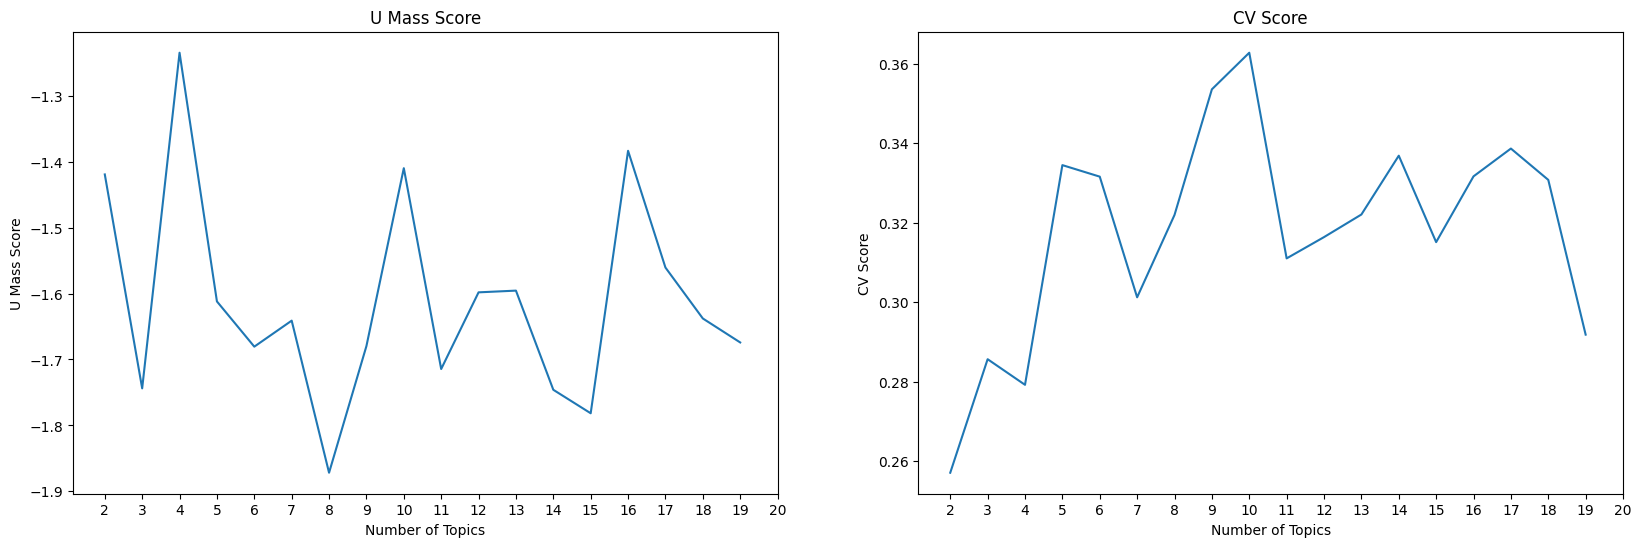

In [77]:
fig, axs= plt.subplots(ncols = 2, figsize=(20,6))

ax=axs[0]
ax.set_title('U Mass Score')
ax.set_xlabel('Number of Topics')
ax.set_ylabel('U Mass Score')
ax.plot(numtop, coherence_umass)
ax.set_xticks(np.arange(2, 20+1, 1.0))

ax=axs[1]
ax.set_title('CV Score')
ax.set_xlabel('Number of Topics')
ax.set_ylabel('CV Score')
ax.plot(numtop, coherence_cv)
ax.set_xticks(np.arange(2, 20+1, 1.0))

plt.show()

In [78]:
topics=10
passes = 30 

model = LdaMulticore(num_topics=topics, 
                     corpus=model_corpus,  
                     id2word=dictionary, 
                     passes=passes, 
                     random_state=42,
                     iterations=30 
                    )

In [80]:
model_topics = [(topic_no, re.sub(r'0\.[0-9]+\*', '', model_topic).replace('"', '').split(' + ')) for topic_no, model_topic in model.print_topics(num_topics=topics, num_words=15)]

for i, m in model_topics:
    print(f'Topic {i}:', ", ".join(m[:15])) 

Topic 0: body, competent, european, parliament, /, board, establish, council, commission, rule, infringement, opinion, remedy, judicial, damage
Topic 1: officer, rectification, representative, applicable, cooperate, section, task, staff, undue, obtain, performance, security, knowledge, envisage, regard
Topic 2: behalf, movement, report, type, except, free, natural, person, annual, regard, transmit, articles, statutory, rule, fundamental
Topic 3: report, conviction, annual, control, register, relate, official, criminal, base, good, authorise, offence, security, safeguard, freedom
Topic 4: country, third, transfer, international, decision, chapter, organisation, interest, lead, consent, category, safeguard, specific, legitimate, base
Topic 5: chair, representative, child, contribute, cooperate, consistent, recipient, consistency, effort, designate, identify, year, identification, monitor, section
Topic 6: every, consider, legislative, report, movement, amend, submit, view, regard, consis

In [ ]:
topic_corpus = model[model_corpus]
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(data.text_colloc))]
topic_distros = pd.DataFrame(data=scores, columns=[''])
topic_distros.head()